<a href="https://colab.research.google.com/github/YuvarajCU/Laptop_Price_Predictor_Project/blob/main/Laptop_Price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Laptop Price Prediction

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline


In [36]:
# To upload the data from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
path='/content/drive/MyDrive/Portfolio/Laptop Price Prediction/Dataset.csv'
df=pd.read_csv(path,encoding='latin-1')

##Data Health Review

In [38]:
df.sample(5)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
558,565,HP,15-bw007nv (A10-9620P/6GB/128GB/Radeon,Notebook,15.6,IPS Panel Full HD 1920x1080,AMD A10-Series A10-9620P 2.5GHz,6GB,128GB SSD,AMD Radeon 530,Windows 10,1.91kg,568.9
582,589,HP,ProBook 430,Notebook,13.3,Full HD 1920x1080,Intel Core i3 7100U 2.4GHz,4GB,128GB SSD,Intel HD Graphics 620,Windows 10,1.49kg,719.0
967,981,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i3 7100U 2.4GHz,4GB,500GB HDD,Intel HD Graphics 620,Windows 10,2.04kg,685.0
39,40,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,Nvidia GeForce 930MX,Windows 10,2.1kg,879.0
580,587,Mediacom,SmartBook Edge,Notebook,14.0,IPS Panel Full HD 1920x1080,Intel Celeron Quad Core N3450 1.1GHz,4GB,32GB SSD,Intel HD Graphics 500,Windows 10,1.45kg,389.0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [40]:
# Checking percentage of missing values
(df.isnull().mean()*100).sort_values(ascending = False)

,0
laptop_ID,0.0
Company,0.0
Product,0.0
TypeName,0.0
Inches,0.0
ScreenResolution,0.0
Cpu,0.0
Ram,0.0
Memory,0.0
Gpu,0.0


In [41]:
df.duplicated().sum()

0

In [42]:
df.describe()

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


In [43]:
df.drop(columns=['laptop_ID','Product'],inplace=True)

## Data Analysis & Feature Engineering

####Analysis by RAM

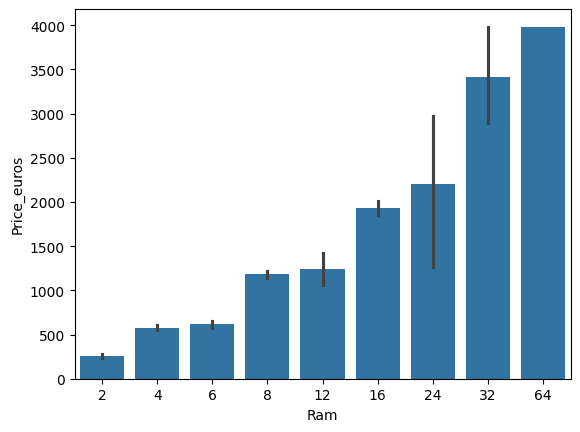

In [44]:
# Extract the numeric values from the Ram column using regular expressions
df['Ram'] = df['Ram'].str.extract('(\d+)').astype(int)

sns.barplot(x= df['Ram'], y= df['Price_euros'])
plt.show()


In [45]:
df['Ram'].describe()

,Ram
count,1303.000000
mean,8.382195
std,5.084665
min,2.000000
25%,4.000000
50%,8.000000
75%,8.000000
max,64.000000


####Analysis by Weight

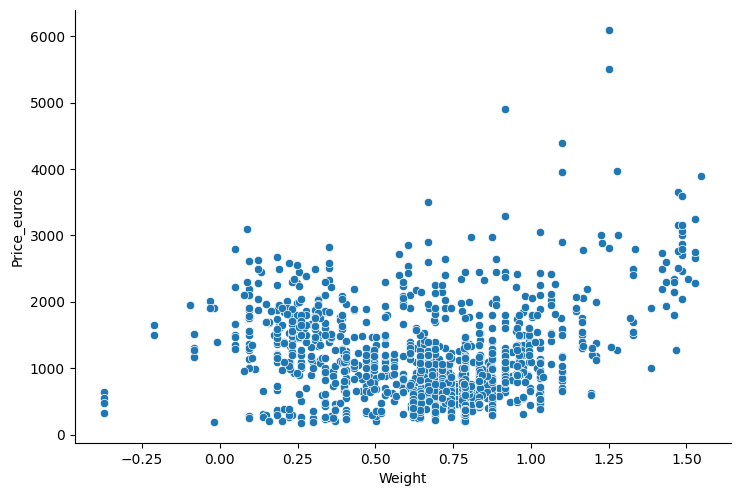

In [46]:
# Extract the numeric values from the Weight column using regular expressions
pattern = r'\d+\.?\d*|\.\d+'

df['Weight'] = df['Weight'].str.extract('(\d+(?:\.\d+)?)').astype(float)

df['Weight'] = np.log(df['Weight'])

sns.pairplot(df, x_vars=['Weight'], y_vars=['Price_euros'], kind='scatter',height=5,aspect=1.5)
plt.show()

####Analysis by Screen Resolution

In [47]:
df['ScreenResolution'].value_counts()

,count
ScreenResolution,
Full HD 1920x1080,507
1366x768,281
IPS Panel Full HD 1920x1080,230
IPS Panel Full HD / Touchscreen 1920x1080,53
Full HD / Touchscreen 1920x1080,47
1600x900,23
Touchscreen 1366x768,16
Quad HD+ / Touchscreen 3200x1800,15
IPS Panel 4K Ultra HD 3840x2160,12


<Axes: xlabel='Touchscreen', ylabel='Price_euros'>

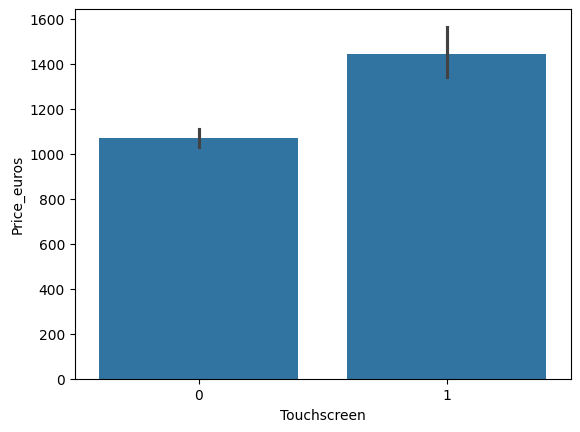

In [48]:
#how many laptops in data are touchscreen
df['Touchscreen'] = df['ScreenResolution'].apply(lambda x:1 if 'Touchscreen' in x else 0)
sns.barplot(x=df['Touchscreen'],y=df['Price_euros'])

<Axes: xlabel='Ips', ylabel='Price_euros'>

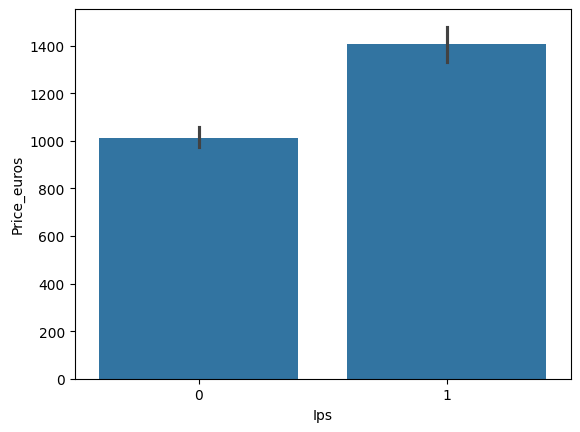

In [49]:
#extract IPS column
df['Ips'] = df['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0)
sns.barplot(x=df['Ips'],y=df['Price_euros'])

In [50]:
def findXresolution(s):
  return s.split()[-1].split("x")[0]
def findYresolution(s):
  return s.split()[-1].split("x")[1]

#finding the x_res and y_res from screen resolution
df['X_res'] = df['ScreenResolution'].apply(lambda x: findXresolution(x))
df['Y_res'] = df['ScreenResolution'].apply(lambda y: findYresolution(y))

#convert to numeric
df['X_res'] = df['X_res'].astype('int')
df['Y_res'] = df['Y_res'].astype('int')

#Replacing inches, X and Y resolution to PPI
df['ppi'] = (((df['X_res']**2) + (df['Y_res']**2))**0.5/df['Inches']).astype('float')
df.drop(columns = ['ScreenResolution', 'Inches','X_res','Y_res'], inplace=True)

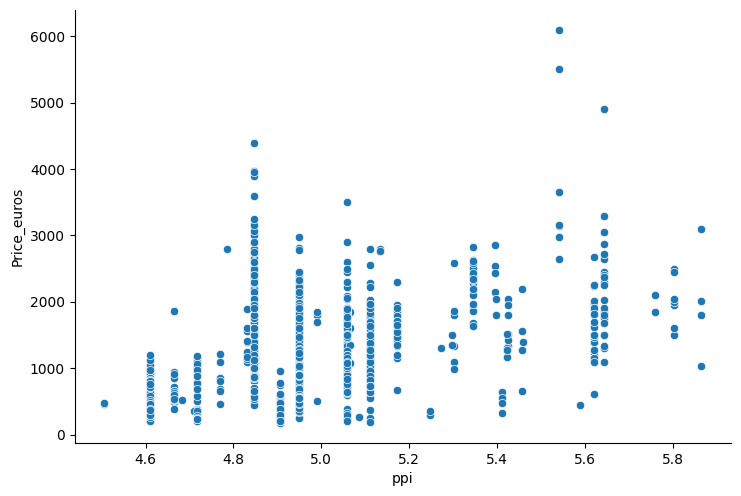

In [51]:
df['ppi']=np.log(df['ppi'])
sns.pairplot(df, x_vars=['ppi'], y_vars=['Price_euros'], kind='scatter',height=5,aspect=1.5)

####Analysis by Processor brand

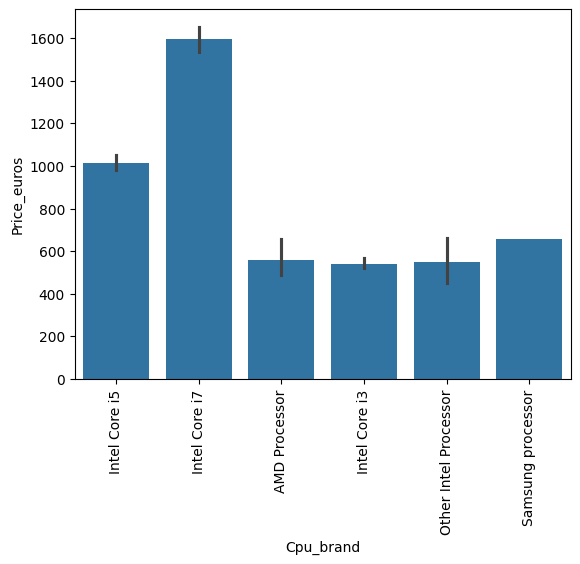

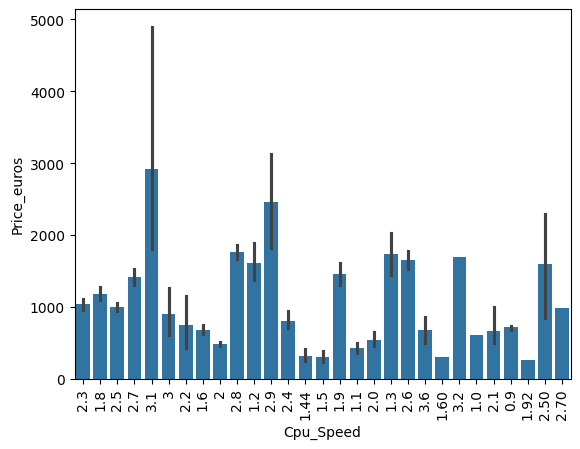

In [52]:
def fetch_processor(x):
  cpu_name = " ".join(x.split()[0:3])
  if cpu_name == 'Intel Core i7' or cpu_name == 'Intel Core i5' or cpu_name == 'Intel Core i3':
    return cpu_name
  elif cpu_name.split()[0] == 'Intel':
    return 'Other Intel Processor'
  elif cpu_name.split()[0] == 'AMD':
      return 'AMD Processor'
  else:
    return 'Samsung processor'

df['Cpu_brand'] = df['Cpu'].apply(lambda x: fetch_processor(x))

df['Cpu_Speed'] = df['Cpu'].apply(lambda x: x.split()[-1].replace('GHz', ''))

sns.barplot(x=df['Cpu_brand'],y=df['Price_euros'])
plt.xticks(rotation='vertical')
plt.show()

sns.barplot(x=df['Cpu_Speed'],y=df['Price_euros'])
plt.xticks(rotation='vertical')
plt.show()

df.drop(columns=['Cpu'],inplace=True)


####Analysis by Memory

In [53]:
df.loc[:, 'Memory'] = df['Memory'].astype(str).replace('\.0', '', regex=True)
df.loc[:, "Memory"] = df["Memory"].str.replace('GB', '')
df.loc[:, "Memory"] = df["Memory"].str.replace('TB', '000')
new = df["Memory"].str.split("+", n=1, expand=True)

df.loc[:, "first"] = new[0]
df.loc[:, "first"] = df["first"].str.strip()

df.loc[:, "second"] = new[1]

df.loc[:, "Layer1HDD"] = df["first"].apply(lambda x: 1 if "HDD" in x else 0)
df.loc[:, "Layer1SSD"] = df["first"].apply(lambda x: 1 if "SSD" in x else 0)
df.loc[:, "Layer1Hybrid"] = df["first"].apply(lambda x: 1 if "Hybrid" in x else 0)
df.loc[:, "Layer1Flash_Storage"] = df["first"].apply(lambda x: 1 if "Flash Storage" in x else 0)

df.loc[:, 'first'] = df['first'].str.replace(r'\D+', '', regex=True)

# Replace inplace fillna with .loc
df.loc[:, "second"] = df["second"].fillna("0")  # This line is changed

df.loc[:, "Layer2HDD"] = df["second"].apply(lambda x: 1 if "HDD" in x else 0)
df.loc[:, "Layer2SSD"] = df["second"].apply(lambda x: 1 if "SSD" in x else 0)
df.loc[:, "Layer2Hybrid"] = df["second"].apply(lambda x: 1 if "Hybrid" in x else 0)
df.loc[:, "Layer2Flash_Storage"] = df["second"].apply(lambda x: 1 if "Flash Storage" in x else 0)

df.loc[:, 'second'] = df['second'].str.replace(r'\D+', '', regex=True)

df.loc[:, "first"] = pd.to_numeric(df["first"], errors='coerce').fillna(0).astype(int)
df.loc[:, "second"] = pd.to_numeric(df["second"], errors='coerce').fillna(0).astype(int)

df.loc[:, "HDD"] = (df["first"] * df["Layer1HDD"] + df["second"] * df["Layer2HDD"])
df.loc[:, "SSD"] = (df["first"] * df["Layer1SSD"] + df["second"] * df["Layer2SSD"])
df.loc[:, "Hybrid"] = (df["first"] * df["Layer1Hybrid"] + df["second"] * df["Layer2Hybrid"])
df.loc[:, "Flash_Storage"] = (df["first"] * df["Layer1Flash_Storage"] + df["second"] * df["Layer2Flash_Storage"])

df.drop(columns=['first', 'second', 'Layer1HDD', 'Layer1SSD', 'Layer1Hybrid',
                 'Layer1Flash_Storage', 'Layer2HDD', 'Layer2SSD', 'Layer2Hybrid',
                 'Layer2Flash_Storage'], inplace=True)

In [54]:
df.drop(columns=['Memory','Hybrid','Flash_Storage'],inplace=True)

In [55]:
df.sample(5)

,Company,TypeName,Ram,Gpu,OpSys,Weight,Price_euros,Touchscreen,Ips,ppi,Cpu_brand,Cpu_Speed,HDD,SSD
686,HP,Notebook,4,AMD Radeon 520,Windows 10,0.620576,612.61,0,0,4.609707,Intel Core i5,2.5,500,0
169,HP,Notebook,4,Intel UHD Graphics 620,Windows 10,0.398776,754.00,0,1,5.109769,Intel Core i5,1.6,500,0
1029,HP,Notebook,8,Nvidia GeForce 930MX,Windows 10,0.966984,1080.00,0,0,4.846827,Intel Core i5,2.5,0,256
1290,Dell,Notebook,6,Intel HD Graphics 620,Windows 10,0.832909,459.00,0,0,4.609707,Intel Core i3,2.4,1000,0
149,Acer,Notebook,4,Intel HD Graphics 520,Windows 10,0.741937,447.00,0,0,4.609707,Intel Core i3,2,1000,0


####Analysis by Gpu

In [56]:
df['Gpu'].value_counts()

,count
Gpu,
Intel HD Graphics 620,281
Intel HD Graphics 520,185
Intel UHD Graphics 620,68
Nvidia GeForce GTX 1050,66
Nvidia GeForce GTX 1060,48
...,...
AMD Radeon R5 520,1
AMD Radeon R7,1
Intel HD Graphics 540,1


<ipython-input-57-9ee2174bbcd4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Gpu'],inplace=True)


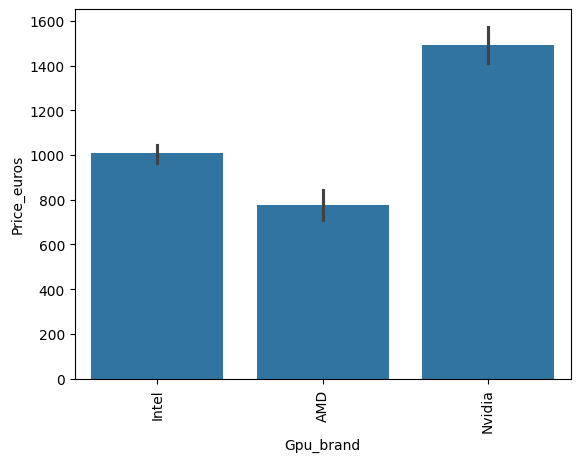

In [57]:
# Which brand GPU is in laptop
df['Gpu_brand'] = df['Gpu'].apply(lambda x:x.split()[0])
#there is only 1 row of ARM GPU so remove it
df = df[df['Gpu_brand'] != 'ARM']
df.drop(columns=['Gpu'],inplace=True)

sns.barplot(x=df['Gpu_brand'],y=df['Price_euros'])
plt.xticks(rotation='vertical')
plt.show()

#### Analysis by Company

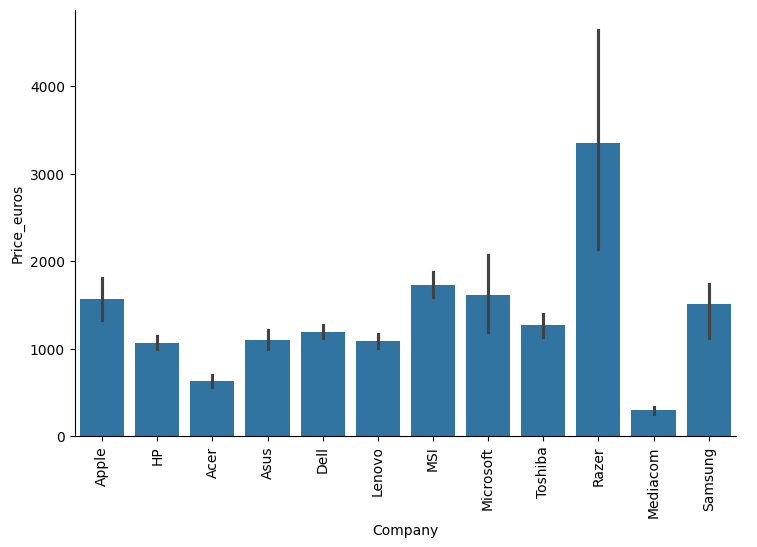

In [58]:
counts = df['Company'].value_counts()
mask = counts < 5
to_remove = counts[mask].index.tolist()
df = df[~df['Company'].isin(to_remove)]
sns.catplot(x='Company', y='Price_euros', kind='bar', data=df,height=5,aspect=1.5).set_xticklabels(rotation=90)

####Analysis by Typename & OpSys

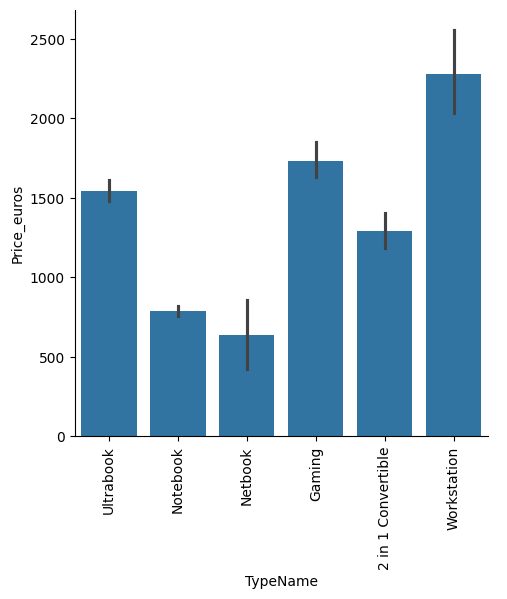

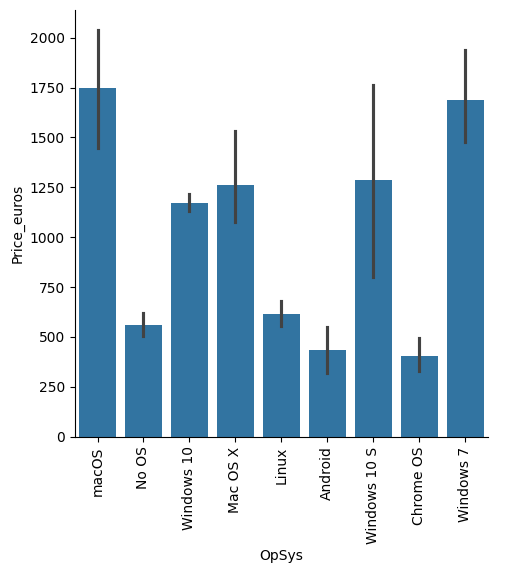

In [59]:
sns.catplot(x='TypeName', y='Price_euros', kind='bar', data=df).set_xticklabels(rotation=90)
sns.catplot(x='OpSys', y='Price_euros', kind='bar', data=df).set_xticklabels(rotation=90)

plt.show()


#### Summary of Data Analysis

As our primary motive is to train, test and predict the price of the laptops based on this dataset,a comprehensive Analysis of the various variables of the dataset are done against the Price data.

These are the changes made in order to make the analysis more efficient and effective:



1. The Data in **Ram & Weight** variables were made numerical by removing their respective units
2. The **ScreenResolution** Varaible has been split into 3 variables- **Tourchscreen, Ips & ppi(resolution) **
3. **Cpu & Gpu** variables were used to get **Cpu_brand & Gpu_brand** variables
4. The **Memory** Variable were used to get various information and finally made into two variables- **SSD & HDD**, containing the size of the memory in each respectively.
5. The variable **Company** had **more unique values** and few of those were made very few observations in the dataset, as removing such least observed company data help us to reduce the overfitting while performing the Linear regression through encoding, we have removed company data that had less than 5 observations
6. Later, the variables - **Memory, Cpu, Gpu, ScreenResolution** were removed,while the variables **Laptop ID & Product** were removed as they had least use for the model building.
7. The distribution of data of variable **Weight is normalised** using log function to have a better distribution of the data.


In [60]:
categorical = [col for col in df.columns if df[col].dtypes == 'O']
print('The Categorical variables are : \n ', categorical)

The Categorical variables are : 
  ['Company', 'TypeName', 'OpSys', 'Cpu_brand', 'Cpu_Speed', 'HDD', 'SSD', 'Gpu_brand']


In [61]:
Numerical = [col for col in df.columns if (df[col].dtypes == 'int64') or (df[col].dtypes == 'float64') ]
print('The Numerical variables are : \n ', Numerical)

The Numerical variables are : 
  ['Ram', 'Weight', 'Price_euros', 'Touchscreen', 'Ips', 'ppi']


In [62]:
df.sample(3)

,Company,TypeName,Ram,OpSys,Weight,Price_euros,Touchscreen,Ips,ppi,Cpu_brand,Cpu_Speed,HDD,SSD,Gpu_brand
1021,Toshiba,Ultrabook,8,Windows 10,0.182322,1590.0,0,0,5.109769,Intel Core i5,2.3,0,256,Intel
507,Acer,Notebook,4,Windows 10,0.788457,613.0,0,1,4.950262,Intel Core i5,1.6,1000,0,Nvidia
1229,MSI,Gaming,8,Windows 10,0.788457,1149.0,0,0,4.950262,Intel Core i7,2.8,1000,128,Nvidia


##Model Building

####Correlation & VIF

                  Ram    Weight  Price_euros  Touchscreen       Ips       ppi
Ram          1.000000  0.294918     0.742757     0.113817  0.208144  0.323767
Weight       0.294918  1.000000     0.105604    -0.333076 -0.036143 -0.410490
Price_euros  0.742757  0.105604     1.000000     0.185204  0.252234  0.504313
Touchscreen  0.113817 -0.333076     0.185204     1.000000  0.152308  0.440306
Ips          0.208144 -0.036143     0.252234     0.152308  1.000000  0.329657
ppi          0.323767 -0.410490     0.504313     0.440306  0.329657  1.000000


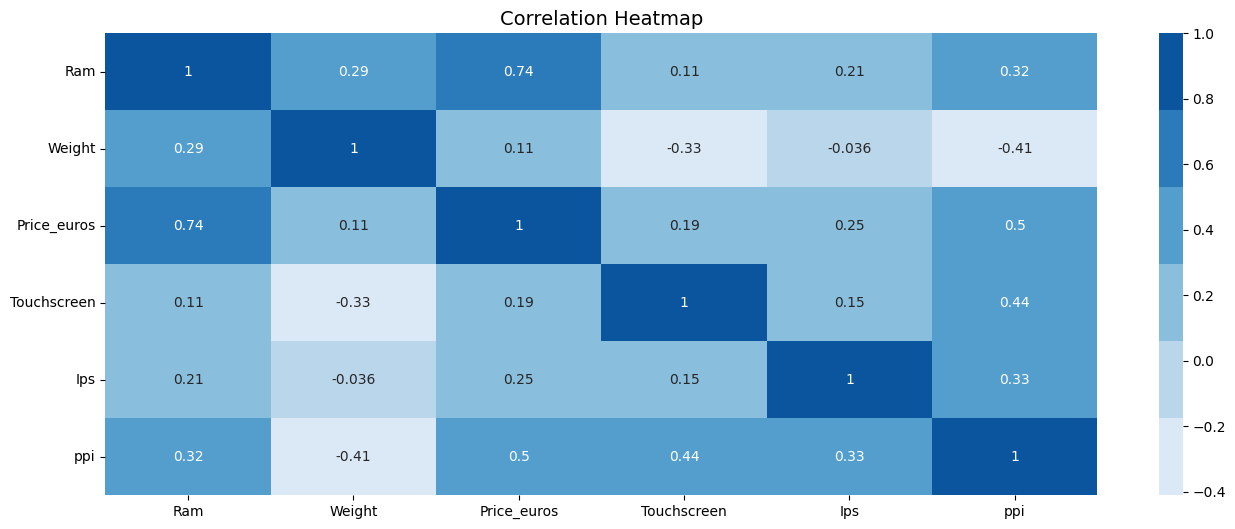

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

corr = df.select_dtypes(include=np.number).corr()
print(corr)

plt.figure(figsize=(16, 6))
colormap = sns.color_palette("Blues")
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap=colormap).set_title('Correlation Heatmap', fontdict={'fontsize':14})
plt.show()

In [66]:
X=df[[col for col in df.columns if (df[col].dtypes == 'int64') or (df[col].dtypes == 'float64') ]]
# calculate the VIF for each variable
vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# display the VIF values
print(vif)


      features       VIF
0          Ram  9.354233
1       Weight  6.690568
2  Price_euros  8.657590
3  Touchscreen  1.437588
4          Ips  1.504704
5          ppi  8.352421


##Models

In [74]:
df.head()

,Company,TypeName,Ram,OpSys,Weight,Price_euros,Touchscreen,Ips,ppi,Cpu_brand,Cpu_Speed,HDD,SSD,Gpu_brand
0,Apple,Ultrabook,8,macOS,0.314811,1339.69,0,1,5.424875,Intel Core i5,2.3,0,128,Intel
1,Apple,Ultrabook,8,macOS,0.292670,898.94,0,0,4.849511,Intel Core i5,1.8,0,0,Intel
2,HP,Notebook,8,No OS,0.620576,575.00,0,0,4.950262,Intel Core i5,2.5,0,256,Intel
3,Apple,Ultrabook,16,macOS,0.604316,2537.45,0,1,5.396055,Intel Core i7,2.7,0,512,AMD
4,Apple,Ultrabook,8,macOS,0.314811,1803.60,0,1,5.424875,Intel Core i5,3.1,0,256,Intel


###Simple Linear Regression

####Model 1: Vs Company

In [75]:
# define the predictor variable and response variable
X = df[['Company']]
y = df['Price_euros']

# one-hot encode the categorical variable
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])])
X = ct.fit_transform(X)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=3)

# train the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# make predictions on the test data
y_pred = regressor.predict(X_test)

accuracies_neg_mse = cross_val_score(estimator=regressor, X=X_train, y=y_train, cv=25, scoring='neg_mean_squared_error').mean()
accuracies = cross_val_score(estimator=regressor, X=X_train, y=y_train, cv=25).mean()

print(f"R2 Score : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"MAE : {mean_absolute_error(y_test,y_pred)*100:.2f}%")
print(f"MSE : {mean_squared_error(y_test,y_pred)*100:.2f}%")
print("Cross Val Accuracy in terms of negative MSE: {:.2f} %".format(accuracies_neg_mse.mean()*100))
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))

model_comparison={}
model_comparison['SLR Vs Company']=[r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),mean_absolute_error(y_test,y_pred),accuracies_neg_mse.mean(),accuracies.mean()]

R2 Score : 13.12%
MAE : 46534.08%
MSE : 36805015.12%
Cross Val Accuracy in terms of negative MSE: -43746846.58 %
Cross Val Accuracy: 9.71 %


####Model 2: Vs Ram

In [76]:
# Define the predictor variable and response variable
X = df['Ram']
y = df['Price_euros']

# Add a constant term to the predictor variable to fit an intercept
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=3)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracies_neg_mse = cross_val_score(estimator=regressor, X=X_train, y=y_train, cv=25, scoring='neg_mean_squared_error').mean()
accuracies = cross_val_score(estimator=regressor, X=X_train, y=y_train, cv=25).mean()

print(f"R2 Score : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"MAE : {mean_absolute_error(y_test,y_pred)*100:.2f}%")
print(f"MSE : {mean_squared_error(y_test,y_pred)*100:.2f}%")
print("Cross Val Accuracy in terms of negative MSE: {:.2f} %".format(accuracies_neg_mse.mean()*100))
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))

model_comparison['SLR Vs Ram']=[r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),mean_absolute_error(y_test,y_pred),accuracies_neg_mse.mean(),accuracies.mean()]

                            OLS Regression Results                            
Dep. Variable:            Price_euros   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     1573.
Date:                Wed, 09 Oct 2024   Prob (F-statistic):          6.88e-225
Time:                        12:13:44   Log-Likelihood:                -9686.5
No. Observations:                1280   AIC:                         1.938e+04
Df Residuals:                    1278   BIC:                         1.939e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        270.6929     25.223     10.732      0.0

####Model 3: Vs ppi

In [77]:
# Define the predictor variable and response variable
X = df['ppi']
y = df['Price_euros']

# Add a constant term to the predictor variable to fit an intercept
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=3)

model = LinearRegression()
model.fit(X_train, y_train)

from sklearn.metrics import r2_score
y_pred = model.predict(X_test)

accuracies_neg_mse = cross_val_score(estimator=regressor, X=X_train, y=y_train, cv=25, scoring='neg_mean_squared_error').mean()
accuracies = cross_val_score(estimator=regressor, X=X_train, y=y_train, cv=25).mean()

print(f"R2 Score : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"MAE : {mean_absolute_error(y_test,y_pred)*100:.2f}%")
print(f"MSE : {mean_squared_error(y_test,y_pred)*100:.2f}%")
print("Cross Val Accuracy in terms of negative MSE: {:.2f} %".format(accuracies_neg_mse.mean()*100))
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))

model_comparison['SLR Vs ppi']=[r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),mean_absolute_error(y_test,y_pred),accuracies_neg_mse.mean(),accuracies.mean()]

                            OLS Regression Results                            
Dep. Variable:            Price_euros   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     435.9
Date:                Wed, 09 Oct 2024   Prob (F-statistic):           1.59e-83
Time:                        12:13:45   Log-Likelihood:                -10012.
No. Observations:                1280   AIC:                         2.003e+04
Df Residuals:                    1278   BIC:                         2.004e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5827.2757    333.450    -17.476      0.0

####Model 4: Vs Weight

In [78]:
# Define the predictor variable and response variable
X = df['Weight']
y = df['Price_euros']

# Add a constant term to the predictor variable to fit an intercept
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=3)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracies_neg_mse = cross_val_score(estimator=regressor, X=X_train, y=y_train, cv=25, scoring='neg_mean_squared_error').mean()
accuracies = cross_val_score(estimator=regressor, X=X_train, y=y_train, cv=25).mean()

print(f"R2 Score : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"MAE : {mean_absolute_error(y_test,y_pred)*100:.2f}%")
print(f"MSE : {mean_squared_error(y_test,y_pred)*100:.2f}%")
print("Cross Val Accuracy in terms of negative MSE: {:.2f} %".format(accuracies_neg_mse.mean()*100))
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))

model_comparison['SLR Vs Weight']=[r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),mean_absolute_error(y_test,y_pred),accuracies_neg_mse.mean(),accuracies.mean()]

                            OLS Regression Results                            
Dep. Variable:            Price_euros   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     14.41
Date:                Wed, 09 Oct 2024   Prob (F-statistic):           0.000154
Time:                        12:13:46   Log-Likelihood:                -10193.
No. Observations:                1280   AIC:                         2.039e+04
Df Residuals:                    1278   BIC:                         2.040e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        968.6449     45.692     21.199      0.0

####Model 5: Vs HDD

In [80]:
# Define the predictor variable and response variable
X = df['HDD']
y = df['Price_euros']

# Convert 'HDD' column to numeric type
X = pd.to_numeric(X, errors='coerce')  # 'coerce' will replace non-numeric values with NaN

# Add a constant term to the predictor variable to fit an intercept
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=3)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracies_neg_mse = cross_val_score(estimator=regressor, X=X_train, y=y_train, cv=25, scoring='neg_mean_squared_error').mean()
accuracies = cross_val_score(estimator=regressor, X=X_train, y=y_train, cv=25).mean()

print(f"R2 Score : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"MAE : {mean_absolute_error(y_test,y_pred)*100:.2f}%")
print(f"MSE : {mean_squared_error(y_test,y_pred)*100:.2f}%")
print("Cross Val Accuracy in terms of negative MSE: {:.2f} %".format(accuracies_neg_mse.mean()*100))
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))

model_comparison['SLR Vs HDD']=[r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),mean_absolute_error(y_test,y_pred),accuracies_neg_mse.mean(),accuracies.mean()]

                            OLS Regression Results                            
Dep. Variable:            Price_euros   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     12.72
Date:                Wed, 09 Oct 2024   Prob (F-statistic):           0.000376
Time:                        12:23:12   Log-Likelihood:                -10194.
No. Observations:                1280   AIC:                         2.039e+04
Df Residuals:                    1278   BIC:                         2.040e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1182.0421     25.079     47.132      0.0

###Multilinear Regression

####Model 1 : with all the selected variables

In [81]:
X = df.drop(columns=['Price_euros'])
y = df['Price_euros']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=3)

ct = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), [0,1,3,8,12])
    ], remainder='passthrough')

pipe = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', LinearRegression())
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

accuracies_neg_mse = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=25, scoring='neg_mean_squared_error').mean()
accuracies = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=25).mean()

print(f"R2 Score : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"MAE : {mean_absolute_error(y_test,y_pred)*100:.2f}%")
print(f"MSE : {mean_squared_error(y_test,y_pred)*100:.2f}%")
print("Cross Val Accuracy in terms of negative MSE: {:.2f} %".format(accuracies_neg_mse.mean()*100))
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))

model_comparison['MLR with all vairiables']=[r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),mean_absolute_error(y_test,y_pred),accuracies_neg_mse.mean(),accuracies.mean()]

R2 Score : 76.19%
MAE : 22983.08%
MSE : 10086537.06%
Cross Val Accuracy in terms of negative MSE: -11874004.49 %
Cross Val Accuracy: 75.08 %


#### Model 2 : Except Company


In [82]:
X = df.drop(columns=['Price_euros','Company'])
y = np.log(df['Price_euros'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=3)
X_train

,TypeName,Ram,OpSys,Weight,Touchscreen,Ips,ppi,Cpu_brand,Cpu_Speed,HDD,SSD,Gpu_brand
345,Gaming,16,Windows 10,0.875469,0,1,4.950262,Intel Core i7,2.8,2000,256,Nvidia
560,2 in 1 Convertible,4,Windows 10,0.223144,1,1,5.246528,Other Intel Processor,2.0,0,0,Intel
203,Gaming,16,Windows 10,1.163151,0,1,4.950262,Intel Core i7,2.8,1000,512,Nvidia
897,Notebook,8,Windows 10,0.712950,0,0,4.950262,Intel Core i7,2.7,1000,0,Nvidia
625,Notebook,8,Windows 10,0.788457,0,0,4.950262,Intel Core i7,2.7,1000,0,Nvidia
...,...,...,...,...,...,...,...,...,...,...,...,...
805,Netbook,8,Windows 10,0.231112,0,0,4.831249,Intel Core i5,2.6,0,256,Intel
262,Notebook,4,Windows 10,0.741937,0,1,4.950262,Intel Core i5,1.6,500,0,Intel
988,Notebook,8,Windows 10,0.858662,0,0,4.609707,Intel Core i7,2.7,1000,0,AMD
971,Ultrabook,8,Windows 10,0.405465,1,0,5.346158,Intel Core i7,2.6,0,256,Intel


In [85]:
# Identify categorical features - change to match your actual data
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Create ColumnTransformer with OneHotEncoder for categorical features
ct = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Passthrough numerical features
)


pipe = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', LinearRegression())
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

accuracies_neg_mse = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=25, scoring='neg_mean_squared_error').mean()
accuracies = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=25).mean()

print(f"R2 Score : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"MAE : {mean_absolute_error(y_test,y_pred)*100:.2f}%")
print(f"MSE : {mean_squared_error(y_test,y_pred)*100:.2f}%")
print("Cross Val Accuracy in terms of negative MSE: {:.2f} %".format(accuracies_neg_mse.mean()*100))
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))

model_comparison['MLR w/o company']=[r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),mean_absolute_error(y_test,y_pred),accuracies_neg_mse.mean(),accuracies.mean()]

R2 Score : 81.11%
MAE : 19.47%
MSE : 6.33%
Cross Val Accuracy in terms of negative MSE: -1049984118062037204992.00 %
Cross Val Accuracy: -2747879853514343055360.00 %


#### Model 3: Except HDD


In [87]:
X = df.drop(columns=['Price_euros','HDD'])
y = np.log(df['Price_euros'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=3)
X_train

,Company,TypeName,Ram,OpSys,Weight,Touchscreen,Ips,ppi,Cpu_brand,Cpu_Speed,SSD,Gpu_brand
345,Lenovo,Gaming,16,Windows 10,0.875469,0,1,4.950262,Intel Core i7,2.8,256,Nvidia
560,Acer,2 in 1 Convertible,4,Windows 10,0.223144,1,1,5.246528,Other Intel Processor,2.0,0,Intel
203,Lenovo,Gaming,16,Windows 10,1.163151,0,1,4.950262,Intel Core i7,2.8,512,Nvidia
897,HP,Notebook,8,Windows 10,0.712950,0,0,4.950262,Intel Core i7,2.7,0,Nvidia
625,Lenovo,Notebook,8,Windows 10,0.788457,0,0,4.950262,Intel Core i7,2.7,0,Nvidia
...,...,...,...,...,...,...,...,...,...,...,...,...
805,HP,Netbook,8,Windows 10,0.231112,0,0,4.831249,Intel Core i5,2.6,256,Intel
262,HP,Notebook,4,Windows 10,0.741937,0,1,4.950262,Intel Core i5,1.6,0,Intel
988,Dell,Notebook,8,Windows 10,0.858662,0,0,4.609707,Intel Core i7,2.7,0,AMD
971,Dell,Ultrabook,8,Windows 10,0.405465,1,0,5.346158,Intel Core i7,2.6,256,Intel


In [89]:
# Identify categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Create ColumnTransformer with OneHotEncoder for categorical features
ct = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Passthrough numerical features
)

pipe = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', LinearRegression())
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

accuracies_neg_mse = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=25, scoring='neg_mean_squared_error').mean()
accuracies = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=25).mean()

print(f"R2 Score : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"MAE : {mean_absolute_error(y_test,y_pred)*100:.2f}%")
print(f"MSE : {mean_squared_error(y_test,y_pred)*100:.2f}%")
print("Cross Val Accuracy in terms of negative MSE: {:.2f} %".format(accuracies_neg_mse.mean()*100))
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))

model_comparison['MLR w/o HDD']=[r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),mean_absolute_error(y_test,y_pred),accuracies_neg_mse.mean(),accuracies.mean()]

R2 Score : 81.47%
MAE : 19.42%
MSE : 6.21%
Cross Val Accuracy in terms of negative MSE: -5.88 %
Cross Val Accuracy: 84.07 %


### Using Grid Search

####Model 4

In [90]:
X = df.drop(columns=['Price_euros'])
y = df['Price_euros']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=3)

X_train

,Company,TypeName,Ram,OpSys,Weight,Touchscreen,Ips,ppi,Cpu_brand,Cpu_Speed,HDD,SSD,Gpu_brand
345,Lenovo,Gaming,16,Windows 10,0.875469,0,1,4.950262,Intel Core i7,2.8,2000,256,Nvidia
560,Acer,2 in 1 Convertible,4,Windows 10,0.223144,1,1,5.246528,Other Intel Processor,2.0,0,0,Intel
203,Lenovo,Gaming,16,Windows 10,1.163151,0,1,4.950262,Intel Core i7,2.8,1000,512,Nvidia
897,HP,Notebook,8,Windows 10,0.712950,0,0,4.950262,Intel Core i7,2.7,1000,0,Nvidia
625,Lenovo,Notebook,8,Windows 10,0.788457,0,0,4.950262,Intel Core i7,2.7,1000,0,Nvidia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,HP,Netbook,8,Windows 10,0.231112,0,0,4.831249,Intel Core i5,2.6,0,256,Intel
262,HP,Notebook,4,Windows 10,0.741937,0,1,4.950262,Intel Core i5,1.6,500,0,Intel
988,Dell,Notebook,8,Windows 10,0.858662,0,0,4.609707,Intel Core i7,2.7,1000,0,AMD
971,Dell,Ultrabook,8,Windows 10,0.405465,1,0,5.346158,Intel Core i7,2.6,0,256,Intel


In [91]:
ct = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), [0,1,3,8,12])
    ], remainder='passthrough')

pipe = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', LinearRegression())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__fit_intercept': [True, False],
    'preprocessor__onehot__handle_unknown': ['error', 'ignore']
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and mean cross-validated score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best neg_mean_squared_error: ", grid_search.best_score_)

# Get the best estimator from the grid search
best_model1 = grid_search.best_estimator_

# Fit the best estimator on the training data
best_model1.fit(X_train, y_train)

# Predict the target variable on the test data
y_pred = best_model1.predict(X_test)

# Calculate the scores you are interested in
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
cv_r2 = cross_val_score(best_model1, X_train, y_train, cv=5, scoring='r2').mean()
cv_neg_mse = cross_val_score(best_model1, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

# Print the scores
print(f"R2 Score : {r2*100:.2f}%")
print(f"MAE : {mae*100:.2f}%")
print(f"MSE : {mse*100:.2f}%")
print("Cross Val Accuracy in terms of R2: {:.2f} %".format(cv_r2.mean()*100))
print("Cross Val Accuracy in terms of Negative MSE: {:.2f} %".format(cv_neg_mse.mean()*100))

model_comparison['MLR using GridSearchCV']=[r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),mean_absolute_error(y_test,y_pred),cv_neg_mse.mean(),cv_r2.mean()]

Best hyperparameters:  {'preprocessor__onehot__handle_unknown': 'error', 'regressor__fit_intercept': True}
Best neg_mean_squared_error:  -116612.2535675359
R2 Score : 76.19%
MAE : 22983.08%
MSE : 10086537.06%
Cross Val Accuracy in terms of R2: 76.63 %
Cross Val Accuracy in terms of Negative MSE: -11661225.36 %


####Model 6 :

In [100]:
X = df.drop(columns=['Price_euros','Weight'])
y = np.log(df['Price_euros'])

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=3)
X_train

,Company,TypeName,Ram,OpSys,Touchscreen,Ips,ppi,Cpu_brand,Cpu_Speed,HDD,SSD,Gpu_brand
345,Lenovo,Gaming,16,Windows 10,0,1,4.950262,Intel Core i7,2.8,2000,256,Nvidia
560,Acer,2 in 1 Convertible,4,Windows 10,1,1,5.246528,Other Intel Processor,2.0,0,0,Intel
203,Lenovo,Gaming,16,Windows 10,0,1,4.950262,Intel Core i7,2.8,1000,512,Nvidia
897,HP,Notebook,8,Windows 10,0,0,4.950262,Intel Core i7,2.7,1000,0,Nvidia
625,Lenovo,Notebook,8,Windows 10,0,0,4.950262,Intel Core i7,2.7,1000,0,Nvidia
...,...,...,...,...,...,...,...,...,...,...,...,...
805,HP,Netbook,8,Windows 10,0,0,4.831249,Intel Core i5,2.6,0,256,Intel
262,HP,Notebook,4,Windows 10,0,1,4.950262,Intel Core i5,1.6,500,0,Intel
988,Dell,Notebook,8,Windows 10,0,0,4.609707,Intel Core i7,2.7,1000,0,AMD
971,Dell,Ultrabook,8,Windows 10,1,0,5.346158,Intel Core i7,2.6,0,256,Intel


In [101]:
ct = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), [0, 1, 3, 7, 10]) # Adjust these column indices if needed
    ],
    remainder='drop'  # Change remainder to 'drop' or apply a different numerical transformation to the remaining columns
)


pipe = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', LinearRegression())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__fit_intercept': [True, False],
    'preprocessor__onehot__handle_unknown': ['error', 'ignore']
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and mean cross-validated score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best neg_mean_squared_error: ", grid_search.best_score_)

# Get the best estimator from the grid search
best_model3 = grid_search.best_estimator_

# Fit the best estimator on the training data
best_model3.fit(X_train, y_train)

# Predict the target variable on the test data
y_pred = best_model3.predict(X_test)

# Calculate the scores you are interested in
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
cv_r2 = cross_val_score(best_model3, X_train, y_train, cv=5, scoring='r2').mean()
cv_neg_mse = cross_val_score(best_model3, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

# Print the scores
print(f"R2 Score : {r2*100:.2f}%")
print(f"MAE : {mae*100:.2f}%")
print(f"MSE : {mse*100:.2f}%")
print("Cross Val Accuracy in terms of R2: {:.2f} %".format(cv_r2.mean()*100))
print("Cross Val Accuracy in terms of Negative MSE: {:.2f} %".format(cv_neg_mse.mean()*100))

model_comparison['MLR using GridSearchCV w/o weight']=[r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),mean_absolute_error(y_test,y_pred),accuracies_neg_mse.mean(),accuracies.mean()]

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 239, in _get_response_values
    y_pred, pos_label = predic

Best hyperparameters:  {'preprocessor__onehot__handle_unknown': 'ignore', 'regressor__fit_intercept': False}
Best neg_mean_squared_error:  -1.7731366975372473e+21
R2 Score : 78.31%
MAE : 20.77%
MSE : 7.27%
Cross Val Accuracy in terms of R2: -456343023613287879147520.00 %
Cross Val Accuracy in terms of Negative MSE: -177313669753724739780608.00 %


In [102]:
X = df.drop(columns=['Price_euros'])
y = df['Price_euros']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=3)
X_train

,Company,TypeName,Ram,OpSys,Weight,Touchscreen,Ips,ppi,Cpu_brand,Cpu_Speed,HDD,SSD,Gpu_brand
345,Lenovo,Gaming,16,Windows 10,0.875469,0,1,4.950262,Intel Core i7,2.8,2000,256,Nvidia
560,Acer,2 in 1 Convertible,4,Windows 10,0.223144,1,1,5.246528,Other Intel Processor,2.0,0,0,Intel
203,Lenovo,Gaming,16,Windows 10,1.163151,0,1,4.950262,Intel Core i7,2.8,1000,512,Nvidia
897,HP,Notebook,8,Windows 10,0.712950,0,0,4.950262,Intel Core i7,2.7,1000,0,Nvidia
625,Lenovo,Notebook,8,Windows 10,0.788457,0,0,4.950262,Intel Core i7,2.7,1000,0,Nvidia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,HP,Netbook,8,Windows 10,0.231112,0,0,4.831249,Intel Core i5,2.6,0,256,Intel
262,HP,Notebook,4,Windows 10,0.741937,0,1,4.950262,Intel Core i5,1.6,500,0,Intel
988,Dell,Notebook,8,Windows 10,0.858662,0,0,4.609707,Intel Core i7,2.7,1000,0,AMD
971,Dell,Ultrabook,8,Windows 10,0.405465,1,0,5.346158,Intel Core i7,2.6,0,256,Intel


In [103]:

# Define the pipeline with preprocessing steps and linear regression model
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['Weight', 'ppi', 'Cpu_Speed']),
        ('cat', categorical_transformer, ['Company', 'TypeName', 'OpSys', 'Cpu_brand', 'Gpu_brand']),
    ])

regressor = Ridge()
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', regressor)])

# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__fit_intercept': [True],
    'preprocessor__cat__handle_unknown': ['error', 'ignore'],
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000,10000], # Ridge Hyperparameter
    'regressor__solver': ['auto', 'lsqr', 'sparse_cg'], # Ridge solver parameter

}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", -1 * grid_search.best_score_)

# Get the best estimator from the grid search
best_model4 = grid_search.best_estimator_

# Fit the best estimator on the training data
best_model4.fit(X_train, y_train)

# Predict the target variable on the test data
y_pred = best_model4.predict(X_test)

# Calculate the scores you are interested in
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
cv_r2 = cross_val_score(best_model4, X_train, y_train, cv=5, scoring='r2').mean()
cv_neg_mse = cross_val_score(best_model4, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()

# Print the scores
print(f"R2 Score : {r2*100:.2f}%")
print(f"MAE : {mae*100:.2f}%")
print(f"MSE : {mse*100:.2f}%")
print("Cross Val Accuracy in terms of R2: {:.2f} %".format(cv_r2.mean()*100))
print("Cross Val Accuracy in terms of Negative MSE: {:.2f} %".format(cv_neg_mse.mean()*100))

model_comparison['MLR using GridSearchCV 1']=[r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),mean_absolute_error(y_test,y_pred),accuracies_neg_mse.mean(),accuracies.mean()]

Best parameters:  {'preprocessor__cat__handle_unknown': 'error', 'regressor__alpha': 1, 'regressor__fit_intercept': True, 'regressor__solver': 'lsqr'}
Best score:  188504.14446771628
R2 Score : 67.98%
MAE : 28149.63%
MSE : 13564561.39%
Cross Val Accuracy in terms of R2: 62.42 %
Cross Val Accuracy in terms of Negative MSE: -18850414.45 %


###Summary on Model Building

1. Models were built using both Simple Linear regression and Multi Linear regression as well and also used grid search for Multi linear regression, a comparison of those models are present in the table below.
2. Before starting to create a model, we had been choosing the varaibles based on various factors mostly based on the Analysis section, thus making all the selected variables to be most useful to build a model.
3. Based on the results below, it very much evident that Simple Linear Regression models arent useful and almost all the MultiLienar Regression models have been producing similar results.
4. With the sole purpose of not to compromise on anymore feature selection, using the Grid Seaech method, we have figured the best of models built here - Model 4, where we have all the selected variables to predict the price of the laoptop, with a cross validation score(neg_MSE) (=-0.068283) almost towards 0 and an r2 score of 80.69%
5. Though their r2 score are good, the errors score are really bad that makes all these model to predict prices with a large error. Thus proving that this problem cant be solved using Linear Regression Method.

In [104]:
df_model_comparison = pd.DataFrame.from_dict(model_comparison, orient='index', columns=['R2 Score', 'MSE', 'MAE', 'Cross_Val_Accuracy_neg_MSE','Cross_Val_Accuracy'])
df_model_comparison

,R2 Score,MSE,MAE,Cross_Val_Accuracy_neg_MSE,Cross_Val_Accuracy
SLR Vs Company,0.131169,368050.151243,465.340754,-4.374685e+05,9.714563e-02
SLR Vs Ram,0.490053,216021.501975,339.691391,-2.240210e+05,5.171329e-01
SLR Vs ppi,0.303464,295063.271757,405.559165,-3.786894e+05,2.255968e-01
SLR Vs Weight,0.013016,418101.559001,518.711173,-4.979039e+05,-2.062300e-02
SLR Vs HDD,-0.023917,433746.972933,514.716099,-4.956640e+05,-1.242696e-02
MLR with all vairiables,0.761894,100865.370570,229.830817,-1.187400e+05,7.508158e-01
MLR w/o company,0.811090,0.063297,0.194666,-1.049984e+19,-2.747880e+19
MLR w/o HDD,0.814688,0.062092,0.194187,-5.878327e-02,8.407453e-01
MLR using GridSearchCV,0.761894,100865.370570,229.830817,-1.166123e+05,7.663150e-01
MLR using GridSearchCV 1,0.679791,135645.613878,281.496327,-5.878327e-02,8.407453e-01


In [109]:
# Split data
X = df.drop(columns=['Price_euros'])
y = df['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=3)

# Define preprocessing steps
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse=False for compatibility with Ridge solvers

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['Weight', 'ppi', 'Cpu_Speed']),
        ('cat', categorical_transformer, ['Company', 'TypeName', 'OpSys', 'Cpu_brand', 'Gpu_brand']),
    ])

# Define the pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', Ridge())])  # or LinearRegression()

# Assuming best_model1 was from a previous GridSearchCV, refit the entire pipeline
best_model1 = pipe  # Reset to the base pipeline
best_model1.fit(X_train, y_train)  # Refit with preprocessor and model together


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Weight', 'ppi',
                                                   'Cpu_Speed']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Company', 'TypeName',
                                                   'OpSys', 'Cpu_brand',
                                                   'Gpu_brand'])])),
                ('regressor', Ridge())])

Train R-squared: 0.6547968486910445
Test R-squared: 0.6799174578803902
Train Adjusted R-squared: 0.6506184120364669
Test Adjusted R-squared: 0.6565406430064861
Train MAE: 292.8930554378583
Test MAE: 281.4294125695705
Train MSE: 172672.4145967974
Test MSE: 135591.8772832552
Train RMSE: 415.538704090001
Test RMSE: 368.2280234898686


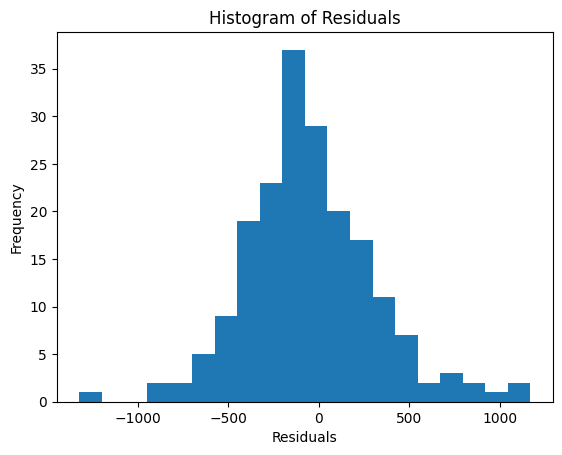

In [110]:
best_model1.fit(X_train, y_train)

# R-squared and Adjusted R-squared values
print('Train R-squared:', best_model1.score(X_train, y_train))
print('Test R-squared:', best_model1.score(X_test, y_test))
n = X_train.shape[0]
p = X_train.shape[1]
train_adj_r2 = 1 - (1 - best_model1.score(X_train, y_train)) * (n - 1) / (n - p - 1)
print('Train Adjusted R-squared:', train_adj_r2)
n = X_test.shape[0]
p = X_test.shape[1]
test_adj_r2 = 1 - (1 - best_model1.score(X_test, y_test)) * (n - 1) / (n - p - 1)
print('Test Adjusted R-squared:', test_adj_r2)

# Performance comparison on Train and Test Samples
y_train_pred = best_model1.predict(X_train)
y_test_pred = best_model1.predict(X_test)
print('Train MAE:', mean_absolute_error(y_train, y_train_pred))
print('Test MAE:', mean_absolute_error(y_test, y_test_pred))
print('Train MSE:', mean_squared_error(y_train, y_train_pred))
print('Test MSE:', mean_squared_error(y_test, y_test_pred))
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

# Histogram of residual deviance on test data
residuals = y_test - y_test_pred
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

In [111]:
# New laptop data
new_laptop = pd.DataFrame({
    'Company': ['Apple'],
    'TypeName': ['Ultrabook'],
    'Ram': [16],
    'OpSys': ['macOS'],
    'Weight': [1.83],
    'Touchscreen': ['No'],
    'Ips': ['Yes'],
    'Inches': [15.4],
    'ScreenResolution': ['2880x1800'],
    'Cpu_brand': ['Intel Core i7'],
    'HDD': ['0'],
    'SSD': ['512'],
    'Gpu_brand': ['AMD']
})

# Calculate ppi based on Inches and ScreenResolution
new_laptop[['Width', 'Height']] = new_laptop['ScreenResolution'].str.split('x', expand=True).astype(int)
new_laptop['ppi'] = ((new_laptop['Width']**2 + new_laptop['Height']**2)**0.5 / new_laptop['Inches']).round().astype(int)
new_laptop.drop(['Width','Height',"ScreenResolution",'Inches'], axis=1, inplace=True)

# Convert 'Touchscreen' and 'Ips' to binary values
new_laptop['Touchscreen'] = (new_laptop['Touchscreen'] == 'Yes').astype(int)
new_laptop['Ips'] = (new_laptop['Ips'] == 'Yes').astype(int)

# Reorder the columns in the new_laptop dataframe to match the order in your dataset
new_laptop = new_laptop[['Company', 'TypeName', 'Ram', 'OpSys', 'Weight', 'Touchscreen', 'Ips', 'ppi', 'Cpu_brand', 'HDD', 'SSD', 'Gpu_brand']]

#df.drop(['Price_euros'], axis=1, inplace=True)
# Append new laptop data to existing dataset
new_data = pd.concat([df, new_laptop], ignore_index=True)


In [112]:
new_data

,Company,TypeName,Ram,OpSys,Weight,Price_euros,Touchscreen,Ips,ppi,Cpu_brand,Cpu_Speed,HDD,SSD,Gpu_brand
0,Apple,Ultrabook,8,macOS,0.314811,1339.69,0,1,5.424875,Intel Core i5,2.3,0,128,Intel
1,Apple,Ultrabook,8,macOS,0.292670,898.94,0,0,4.849511,Intel Core i5,1.8,0,0,Intel
2,HP,Notebook,8,No OS,0.620576,575.00,0,0,4.950262,Intel Core i5,2.5,0,256,Intel
3,Apple,Ultrabook,16,macOS,0.604316,2537.45,0,1,5.396055,Intel Core i7,2.7,0,512,AMD
4,Apple,Ultrabook,8,macOS,0.314811,1803.60,0,1,5.424875,Intel Core i5,3.1,0,256,Intel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,Lenovo,2 in 1 Convertible,16,Windows 10,0.262364,1499.00,1,1,5.620595,Intel Core i7,2.5,0,512,Intel
1277,Lenovo,Notebook,2,Windows 10,0.405465,229.00,0,0,4.717920,Other Intel Processor,1.6,0,0,Intel
1278,HP,Notebook,6,Windows 10,0.783902,764.00,0,0,4.609707,Intel Core i7,2.5,1000,0,AMD
1279,Asus,Notebook,4,Windows 10,0.788457,369.00,0,0,4.609707,Other Intel Processor,1.6,500,0,Intel


In [115]:
# Your code for training and prediction
# Use the best_model1 to make a price prediction for the new laptop
predicted_price = best_model1.predict(new_laptop)[0]
print(f"The predicted price of the new laptop is {predicted_price:.2f} euros")


ValueError: columns are missing: {'Cpu_Speed'}

https://www.analyticsvidhya.com/blog/2021/11/laptop-price-prediction-practical-understanding-of-machine-learning-project-lifecycle/

This Blog gives an insight on how to deploy a model live on a website.

In [ ]:
import pickle
df.to_csv("df.csv", index=False)
pickle.dump(pipe,open('pipe.pkl','wb'))